# MQ Advanced Jupyter Notebook

This Jupyter Notebook is an extension of the Beginner Jupyter Notebook. In this Notebook, we will dive deeper into the code that was introduced in the other notebook and look at the specific implementation of each function.

If you are unfamiliar with Jupyter Notebook, an introduction guide is available in the MQ Beginner Jupyter Notebook. 

<b>It is highly recommended to start with the MQ Beginner Notebook, and only then move to this one.</b>

# Working with IBM MQ on Raspberry Pi Zero


Jupyter Notebooks provides an intuitive interface to running IBM MQ commands on the Raspberry Pi.

In [3]:
# Command to get current IBM MQ version installed on the Pi
!dspmqver

Name:        IBM MQ
Version:     9.1.3.0
Level:       p913-L190712.DE
BuildType:   IKAP - (Production)
Platform:    IBM MQ for Linux (ARM platform)
Mode:        32-bit
O/S:         Linux 4.19.75+
InstName:    Installation1
InstDesc:    
Primary:     No
InstPath:    /opt/mqm
DataPath:    /var/mqm
MaxCmdLevel: 913
LicenseType: Developer


In [4]:
# Get all IBM MQ queue managers on the Pi
!dspmq

QMNAME(QM1)                                               STATUS(Running)


In [5]:
# Optional: If the needed Queue Manager is down, start it using following command.
!strmqm #<insert Queue Manager name here>#

AMQ8118E: IBM MQ queue manager does not exist.


## Connect to Queue Manager - <i>connectToQMGR()</i>

The following scenario will describe a very simple put/get IBM MQ use case. We will be connecting to a Queue Manager (<b>QM1</b>), connecting to the local queue (<b>DEV.QUEUE.1</b>) and then sending and receiving a message. The scenario provided below can be visualized in the following diagram:

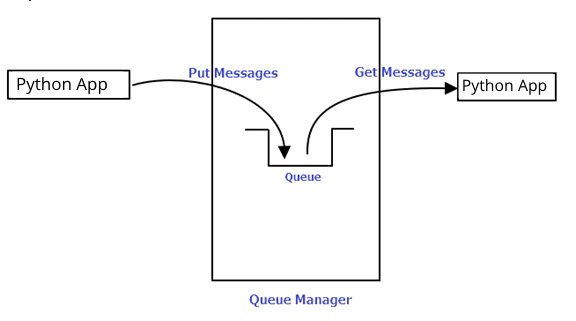

This is a very basic scenario, but has the potential to be extended endlessly. Currently, the messages are sent and received locally on the Raspberry Pi, but the scenario can be extended to send them from a remote device and receive on the Pi, or even send from a remote device and receive on another remote device! The possibilities are endless - the world is your oyster.

### Import packages

To begin, we must import the relevant packages, specifically <a href="https://github.com/dsuch/pymqi">PyMQI</a>, a Python library for working with IBM MQ (formerly WebSphere MQ and MQSeries) implementing MQI and PCF protocols.

In [10]:
import pymqi
from pymqi import CMQC

### Provide connection information to Queue Manager

Next, we must connect to a queue manager on the Raspberry Pi. 

This has been pre-configured for you, but feel free to experiment and edit as needed for your own use case.

In [11]:
queue_manager = 'QM1'                     # Queue Manager Name     
channel = 'DEV.APP.SVRCONN'               # Channel Name through which to connect. 
host = '192.168.4.1'                       # Raspberry Pi IP - do not change!
port = '1414'                             # Default port for IBM MQ to use
queue_name = 'DEV.QUEUE.1'                # Queue name to/from which to send/receive message
conn_info = '%s(%s)' % (host, port)       # Connection information in format ip(port)

user = 'app'                              # Connection username credentials - optional
password = 'password'                     # Connection password credentials - optional

qmgr = pymqi.connect(queue_manager, channel, conn_info, user, password) # Initiating connection to Queue Manager

## Sending and receiving messages from the Queue

### IBM MQ Messages

An IBM MQ <a href="https://www.ibm.com/support/knowledgecenter/en/SSFKSJ_8.0.0/com.ibm.mq.dev.doc/q022860_.htm">message</a> consists of two parts: <b>Message properties</b> and <b>Application data</b>. 


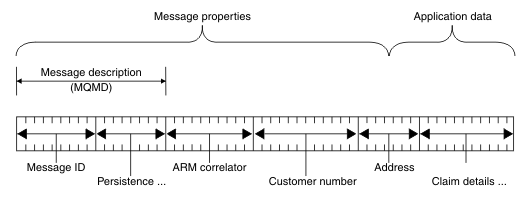


Within the <b>message properties</b>, an important part is the <b>MQMD (Message Description)</b>. The MQMD structure contains the control information that accompanies the application data when a message travels between the sending and receiving applications. 

The <b>application data</b> is the payload that is carried by a message. The application data is never changed by the queue manager unless data conversion is carried out on it. IBM MQ does not put any restrictions on the content of this data. 

The length of the data in each message cannot exceed the value of the <b><i>MaxMsgLength</i></b> attribute of both the queue and queue manager. By default, this is set to 4 MB on distributed systems and 100 MB on z/OS, but can be extended up to 100 MB.





### Custom user input to send as message - <i>createMessagePayload()</i>

To create some message data, we will take a custom user input string.

In [12]:
message = input()

hello world


### Create message headers

As mentioned earlier, we must create a suitable Message Description before sending the message. In this case, we use the default Message Description values, except setting the format to expect a single-byte character set or double-byte character set string (<b>CMQC.MQFMT_STRING</b>). 

In [13]:
md = pymqi.MD()
md.Format = CMQC.MQFMT_STRING

### Put message on Queue - <i>putMessageOnQueue()</i>

Now, we can connect to the Queue:

In [14]:
queue = pymqi.Queue(qmgr, queue_name)

And put the message on the Queue, encoding the message in UTF-8 encoding (default):

In [15]:
queue.put(str.encode(message), md, None)

### Get message from Queue - <i>getMessageFromQueue()</i>

To get message off the Queue, we need to get the application data message. Several `get()` variations exist depending on the use case - `get()` returns the message including all headers, `get_no_jms()` gets the message but discards any JMS headers, `get_no_rfh2()` is an alias for `get_no_jms()`.  

After the message is received from the queue, we can decode from `UTF-8` encoding for output. 

In [16]:
queue = pymqi.Queue(qmgr, queue_name)
message_output = queue.get_no_jms()
print(message_output.decode("utf-8"))

hello world


You can run the code above as often as you like - putting and getting messages from the Queue. Play around with the Text Box interface from the landing page - putting message on the Queue from there and receiving them in this Notebook workspace.

### Close queue when finished

After you are done working with the queue, you should close it. This has to be done only once, and not after every queue interaction. 

In [17]:
queue.close()

### Disconnect from Queue Manager to Finish

Similarly to above, disconnect from the queue manager once you are done using it.

In [18]:
qmgr.disconnect()

## Extending this Scenario

The example provided above demonstrated the basic use case of IBM MQ - sending and receiving message from different applications via a Queue on a Queue Manager. You can extend this example in many ways to fit with your requirements and use cases:

- Send a message from Laptop and receive on Raspberry Pi - download the jar file containing the IBM MQ client and use it to send a message to the Queue on the Queue Manager. From this Notebook or via the <b>runmqsc interface</b>, receive the sent message.

- Send a message from Laptop to another Laptop via IBM MQ on the Raspberry Pi - download the jar files to each of the machines and use one Laptop to send message, and another Laptop to receive message. 

- Incorporate the Python code into your application by copy and pasting the relevant parts into an IDE of your choice - samples for other languages can be found in <a href="https://github.com/ibm-messaging/mq-dev-patterns">the following repo</a>. 

### Using Java

A Java sample is also available on the Raspberry Pi in `/home/pi/samples` and can be copied into an IDE, ready to use. This will allow to connect to the Queue Manager, as well as send and receive messages from the Queue. You need the following three files:

- <b>com.ibm.mq.allclient-9.0.4.0.jar</b> (9.0.4.0. IBM MQ classes for Java and JMS. This artifact is provided by the MQ Development organisation).
- <b>javax.jms-api-2.0.1.jar</b> (JMS API)
- <b>BasicMessageSystem.java</b> (Sample Java code to connect to Queue Manager, send and receive messages)

Navigate to `/home/pi/samples` folder:

In [1]:
!cd /home/pi/samples

/bin/sh: line 0: cd: /home/pi/samples: No such file or directory


If you wish, copy the files to your local machine or compile directly on the Raspberry Pi. 

To copy, from your local machine terminal run:

`scp 172.20.1.1@raspberrypi:/home/pi/samples *directory/where/you/want/to/save*`

To compile and run:

In [ ]:
!javac -cp ./com.ibm.mq.allclient-9.0.4.0.jar:./javax.jms-api-2.0.1.jar BasicMessageSystem.java

In [ ]:
!java -cp ./com.ibm.mq.allclient-9.0.4.0.jar:./javax.jms-api-2.0.1.jar:. BasicMessageSystem